In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from skimage.transform import resize
from skimage.io import imread
from skimage import color

/home/mattmann/install/python37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mattmann/install/python37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mattmann/install/python37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mattmann/install/python37/lib/python3.7/site-pack

In [2]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

In [3]:
def grayscale(a):
    return a.reshape(a.shape[0], 3, 32, 32).mean(1).reshape(a.shape[0], -1)

In [4]:
def clean(data):
    imgs = data.reshape(data.shape[0], 3, 32, 32)
    grayscale_imgs = imgs.mean(1)
    cropped_imgs = grayscale_imgs[:, 4:28, 4:28]
    img_data = cropped_imgs.reshape(data.shape[0], -1)
    img_size = np.shape(img_data)[1]
    means = np.mean(img_data, axis=1)
    meansT = means.reshape(len(means), 1)
    stds = np.std(img_data, axis=1)
    stdsT = stds.reshape(len(stds), 1)
    adj_stds = np.maximum(stdsT, 1.0 / np.sqrt(img_size))
    normalized = (img_data - meansT) / adj_stds
    return normalized

In [5]:
def read_data(directory):
    names = unpickle('{}/batches.meta'.format(directory))['label_names']
    print('names', names)
    data, labels = [], []
    for i in range(1, 6):
        filename = '{}/data_batch_{}'.format(directory, i)
        batch_data = unpickle(filename)
        if len(data) > 0:
            data = np.vstack((data, batch_data['data']))
            labels = np.hstack((labels, batch_data['labels']))
        else:
            data = batch_data['data']
            labels = batch_data['labels']
    print(np.shape(data), np.shape(labels))
    data = clean(data)
    data = data.astype(np.float32)
    return names, data, labels


In [6]:
names, data, labels = read_data('../data/cifar-10-batches-py')
x = tf.placeholder(tf.float32, [None, 24 * 24]) # 5000,576
y = tf.placeholder(tf.float32, [None, len(names)]) # 50000, 10
W1 = tf.Variable(tf.random_normal([5, 5, 1, 64])) # first convo layer with 64 filters size 5x5, one band greyscale, image input size 24x24
b1 = tf.Variable(tf.random_normal([64])) # biases for first convo layer
W2 = tf.Variable(tf.random_normal([5, 5, 64, 64])) # second convo layer with 64 filters size 5x5, run on the 64 outputs of first layer, image input size 12x12
b2 = tf.Variable(tf.random_normal([64])) # biases for the second convo layer
W3 = tf.Variable(tf.random_normal([6*6*64, 1024])) # fully connected layer taking output of convo layer which are 64 image inputs size 6x6 and mapping to 32x32 original image 
b3 = tf.Variable(tf.random_normal([1024])) # biases for fully connected layer
W_out = tf.Variable(tf.random_normal([1024, len(names)])) # output weights for final layer of actual labels, 1024 features  mapped to 10 labels one hot encoded - used for hlf correlations
b_out = tf.Variable(tf.random_normal([len(names)])) # biases for output labels

names ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(50000, 3072) (50000,)


In [7]:
def conv_layer(x, W, b):
    conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    conv_with_b = tf.nn.bias_add(conv, b)
    conv_out = tf.nn.relu(conv_with_b)
    return conv_out

In [8]:
def maxpool_layer(conv, k=2):
    return tf.nn.max_pool(conv, ksize=[1, k, k, 1], strides=[1, k, k, 1],
     padding='SAME')

In [9]:
def model():
    x_reshaped = tf.reshape(x, shape=[-1, 24, 24, 1])
    conv_out1 = conv_layer(x_reshaped, W1, b1)
    maxpool_out1 = maxpool_layer(conv_out1)
    norm1 = tf.nn.lrn(maxpool_out1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
    conv_out2 = conv_layer(norm1, W2, b2)
    norm2 = tf.nn.lrn(conv_out2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
    maxpool_out2 = maxpool_layer(norm2)
    maxpool_reshaped = tf.reshape(maxpool_out2, [-1, W3.get_shape().as_list()[0]])
    local = tf.add(tf.matmul(maxpool_reshaped, W3), b3)
    local_out = tf.nn.relu(local)
    out = tf.add(tf.matmul(local_out, W_out), b_out)
    return out

In [10]:
model_op = model()
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model_op, labels=y))
train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
correct_pred = tf.equal(tf.argmax(model_op, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [11]:
epochs=2000

In [12]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [13]:
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    onehot_labels = tf.one_hot(labels, len(names), on_value=1., off_value=0., axis=-1)
    onehot_vals = sess.run(onehot_labels)
    batch_size = len(data) // 200
    print('batch size', batch_size)
    for j in tqdm(range(0, 1000)):
        #print('EPOCH', j)
        for i in range(0, len(data), batch_size):
            batch_data = data[i:i+batch_size, :]
            batch_onehot_vals = onehot_vals[i:i+batch_size, :]
            _, accuracy_val = sess.run([train_op, accuracy], feed_dict={x:batch_data, y: batch_onehot_vals})
            #if i % 1000 == 0:
            #    print(i, accuracy_val)
        #print('DONE WITH EPOCH')
        print(j, accuracy_val)
  

    saver.save(sess, '../models/cifar10-cnn-tf1n-'+str(epochs)+'epochs.ckpt')

batch size 250


/home/mattmann/install/python37/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0 0.264
1 0.252
2 0.26
3 0.28
4 0.304
5 0.316
6 0.308
7 0.308
8 0.344
9 0.344
10 0.364
11 0.38
12 0.372
13 0.38
14 0.412
15 0.372
16 0.364
17 0.396
18 0.384
19 0.384
20 0.456
21 0.432
22 0.424
23 0.392
24 0.408
25 0.412
26 0.392
27 0.376
28 0.408
29 0.38
30 0.408
31 0.396
32 0.368
33 0.32
34 0.396
35 0.396
36 0.452
37 0.404
38 0.448
39 0.428
40 0.42
41 0.428
42 0.436
43 0.448
44 0.444
45 0.436
46 0.444
47 0.416
48 0.388
49 0.424
50 0.42
51 0.444
52 0.444
53 0.4
54 0.508
55 0.416
56 0.416
57 0.408
58 0.464
59 0.4
60 0.468
61 0.468
62 0.48
63 0.46
64 0.508
65 0.472
66 0.328
67 0.476
68 0.456
69 0.432
70 0.468
71 0.484
72 0.512
73 0.46
74 0.512
75 0.5
76 0.496
77 0.496
78 0.508
79 0.396
80 0.508
81 0.484
82 0.516
83 0.552
84 0.46
85 0.516
86 0.52
87 0.416
88 0.496
89 0.364
90 0.476
91 0.492
92 0.472
93 0.488
94 0.46
95 0.436
96 0.472
97 0.504
98 0.564
99 0.484
100 0.592
101 0.516
102 0.536
103 0.496
104 0.38
105 0.46
106 0.444
107 0.476
108 0.504
109 0.436
110 0.564
111 0.52
112 0.408
113

850 0.824
851 0.828
852 0.816
853 0.84
854 0.816
855 0.82
856 0.812
857 0.804
858 0.848
859 0.816
860 0.772
861 0.804
862 0.804
863 0.808
864 0.792
865 0.8
866 0.816
867 0.816
868 0.756
869 0.732
870 0.756
871 0.752
872 0.752
873 0.748
874 0.784
875 0.788
876 0.808
877 0.812
878 0.78
879 0.776
880 0.744
881 0.74
882 0.788
883 0.756
884 0.86
885 0.816
886 0.804
887 0.796
888 0.84
889 0.816
890 0.776
891 0.768
892 0.748
893 0.768
894 0.748
895 0.74
896 0.768
897 0.764
898 0.78
899 0.748
900 0.792
901 0.724
902 0.752
903 0.764
904 0.72
905 0.7
906 0.772
907 0.732
908 0.768
909 0.756
910 0.76
911 0.756
912 0.768
913 0.812
914 0.764
915 0.772
916 0.744
917 0.736
918 0.752
919 0.748
920 0.76
921 0.792
922 0.808
923 0.82
924 0.84
925 0.772
926 0.816
927 0.832
928 0.836
929 0.836
930 0.9
931 0.868
932 0.796
933 0.744
934 0.768
935 0.772
936 0.804
937 0.804
938 0.784
939 0.796
940 0.8
941 0.812
942 0.796
943 0.788
944 0.772
945 0.776
946 0.804
947 0.792
948 0.788
949 0.768
950 0.812
951 0.812
9

In [14]:
def model_X(x, W1, b1, W2, b2, W3, b3, W_out, b_out):
    x_reshaped = tf.reshape(x, shape=[-1, 24, 24, 1])
    conv_out1 = conv_layer(x_reshaped, W1, b1)
    maxpool_out1 = maxpool_layer(conv_out1)
    norm1 = tf.nn.lrn(maxpool_out1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
    conv_out2 = conv_layer(norm1, W2, b2)
    norm2 = tf.nn.lrn(conv_out2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
    maxpool_out2 = maxpool_layer(norm2)
    maxpool_reshaped = tf.reshape(maxpool_out2, [-1, W3.shape[0]])
    local = tf.add(tf.matmul(maxpool_reshaped, W3), b3)
    local_out = tf.nn.relu(local)
    out = tf.add(tf.matmul(local_out, W_out), b_out)
    return out

In [15]:
def predict(img_data):
    with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess, "../models/cifar10-cnn-tf1n-"+str(epochs)+"epochs.ckpt")
        print("Model restored.")
        W1_val = W1.eval()
        b1_val = b1.eval()
        W2_val = W2.eval()
        b2_val = b2.eval()
        W3_val = W3.eval()
        b3_val = b3.eval()
        W_out_val = W_out.eval()
        b_out_val = b_out.eval()
        model_x_out = model_X(img_data, W1_val, b1_val, W2_val, b2_val, W3_val, b3_val, W_out_val, b_out_val)
        class_num = np.argmax(model_x_out.eval(), axis=1)[0]
        class_name = names[np.argmax(model_x_out.eval(), axis=1)[0]]
        return (class_num, class_name) 

In [16]:
class_num, class_name = predict(data[3])
print('Class Num', class_num)
print('Class', class_name)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../models/cifar10-cnn-tf1n-2000epochs.ckpt
Model restored.
Class Num 4
Class deer


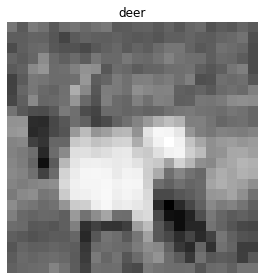

In [17]:
plt.figure()
plt.title(class_name)
img = np.reshape(data[3, :], (24,24))
plt.imshow(img, cmap='Greys_r')
plt.axis('off')
plt.tight_layout()

In [18]:
# test out on test images
def read_test_data(directory):
    names = unpickle('{}/batches.meta'.format(directory))['label_names']
    print('names', names)
    data, labels = [], []
    
    filename = '{}/test_batch'.format(directory)
    batch_data = unpickle(filename)
    if len(data) > 0:
        data = np.vstack((data, batch_data['data']))
        labels = np.hstack((labels, batch_data['labels']))
    else:
        data = batch_data['data']
        labels = batch_data['labels']
    print(np.shape(data), np.shape(labels))
    data = clean(data)
    data = data.astype(np.float32)
    return names, data, labels

In [19]:
test_names, test_data, test_labels = read_test_data('../data/cifar-10-batches-py')

names ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(10000, 3072) (10000,)


In [20]:
test_class_num, test_class_name = predict(test_data[4])
print('Test Class Num', test_class_num)
print('Test Class Name', test_class_name)
print('Actual Class Label', test_labels[4])

INFO:tensorflow:Restoring parameters from ../models/cifar10-cnn-tf1n-2000epochs.ckpt
Model restored.
Test Class Num 6
Test Class Name frog
Actual Class Label 6


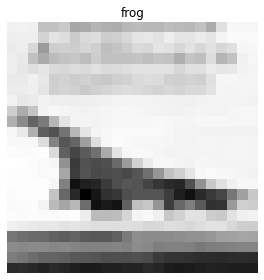

In [21]:
plt.figure()
plt.title(test_class_name)
img = np.reshape(test_data[3, :], (24,24))
plt.imshow(img, cmap='Greys_r')
plt.axis('off')
plt.tight_layout()

In [22]:
def get_test_accuracy(test_data, test_names, test_labels):
    with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess, "../models/cifar10-cnn-tf1n-"+str(epochs)+"epochs.ckpt")
        print("Model restored.")
        W1_val = W1.eval()
        b1_val = b1.eval()
        W2_val = W2.eval()
        b2_val = b2.eval()
        W3_val = W3.eval()
        b3_val = b3.eval()
        W_out_val = W_out.eval()
        b_out_val = b_out.eval()
        model_x_out = model_X(test_data, W1_val, b1_val, W2_val, b2_val, W3_val, b3_val, W_out_val, b_out_val)
        
        onehot_test_labels = tf.one_hot(test_labels, len(test_names), on_value=1., off_value=0., axis=-1)
        test_correct_pred = tf.equal(tf.argmax(model_x_out, 1), tf.argmax(onehot_test_labels, 1))
        test_accuracy = tf.reduce_mean(tf.cast(test_correct_pred, tf.float32))
        
        print('Test accuracy %f' % (test_accuracy.eval()))  
        predictions = tf.argmax(model_x_out, 1).eval()
        return (predictions, tf.cast(test_correct_pred, tf.float32).eval(), onehot_test_labels.eval())

    
predict_vals, test_correct_preds, onehot_test_lbls = get_test_accuracy(test_data, test_names, test_labels)
print(predict_vals)
print(predict_vals.shape)
print(test_correct_preds)
print(test_correct_preds.shape)
print(onehot_test_lbls.shape)

INFO:tensorflow:Restoring parameters from ../models/cifar10-cnn-tf1n-2000epochs.ckpt
Model restored.
Test accuracy 0.532100
[3 1 0 ... 5 1 7]
(10000,)
[1. 0. 0. ... 1. 1. 1.]
(10000,)
(10000, 10)


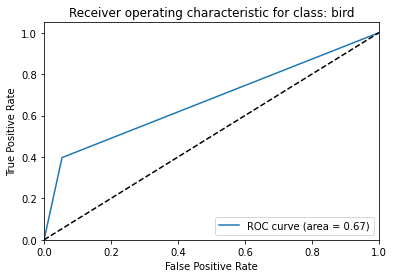

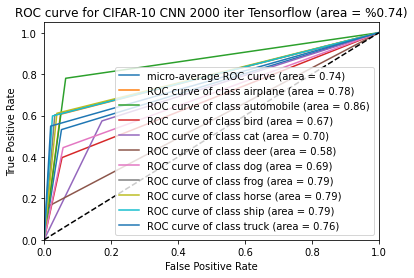

In [23]:
outcome_test = label_binarize(test_labels, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
predictions_test = label_binarize(predict_vals, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = outcome_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(outcome_test[:, i], predictions_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
   
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(outcome_test.ravel(), predictions_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for class: '+test_names[2])
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(test_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
roc_mean = np.mean(np.fromiter(roc_auc.values(), dtype=float))
plt.title('ROC curve for CIFAR-10 CNN 2000 iter Tensorflow (area = %{0:0.2f})'.format(roc_mean))
plt.legend(loc="lower right")
plt.show()

In [24]:
def predict_img_url(url):
    image = color.rgb2gray(imread(url))
    print(image.shape)
    plt.figure()
    plt.title('URL from Internet')
    plt.imshow(image, cmap='Greys_r')
    plt.axis('off')
    plt.tight_layout()
    new_size = 24,24
    image = resize(image, new_size, anti_aliasing=True)
    print(image.shape)
    images = np.expand_dims(image, axis=0)
    print(images.shape)
    im_data = images.astype(np.float32)
    print(im_data.shape)
    prediction = predict(im_data[0])
    print(prediction)
    print("Cropped to 24x24")
    plt.figure()
    plt.title('Pic from Internet (24x24): '+str(prediction[1])) # prediction format is (class num,label)
    plt.imshow(images[0], cmap='Greys_r')
    plt.axis('off')
    plt.tight_layout()
    return prediction


(480, 720)
(24, 24)
(1, 24, 24)
(1, 24, 24)
INFO:tensorflow:Restoring parameters from ../models/cifar10-cnn-tf1n-2000epochs.ckpt
Model restored.
(3, 'cat')
Cropped to 24x24
(619, 1100)
(24, 24)
(1, 24, 24)
(1, 24, 24)
INFO:tensorflow:Restoring parameters from ../models/cifar10-cnn-tf1n-2000epochs.ckpt
Model restored.
(3, 'cat')
Cropped to 24x24
(667, 1000)
(24, 24)
(1, 24, 24)
(1, 24, 24)
INFO:tensorflow:Restoring parameters from ../models/cifar10-cnn-tf1n-2000epochs.ckpt
Model restored.
(3, 'cat')
Cropped to 24x24
(2000, 3008)
(24, 24)
(1, 24, 24)
(1, 24, 24)
INFO:tensorflow:Restoring parameters from ../models/cifar10-cnn-tf1n-2000epochs.ckpt
Model restored.
(3, 'cat')
Cropped to 24x24
(1800, 2400)
(24, 24)
(1, 24, 24)
(1, 24, 24)
INFO:tensorflow:Restoring parameters from ../models/cifar10-cnn-tf1n-2000epochs.ckpt
Model restored.
(3, 'cat')
Cropped to 24x24
(487, 646)
(24, 24)
(1, 24, 24)
(1, 24, 24)
INFO:tensorflow:Restoring parameters from ../models/cifar10-cnn-tf1n-2000epochs.ckpt


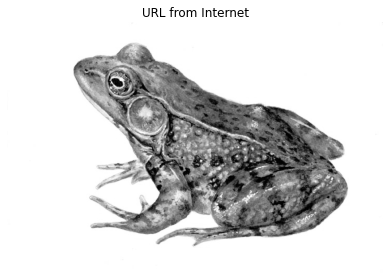

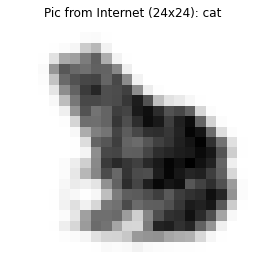

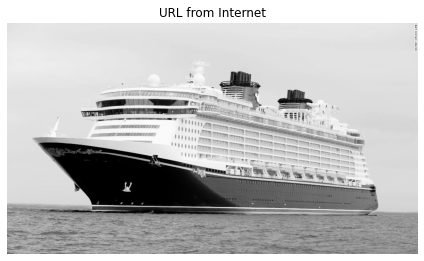

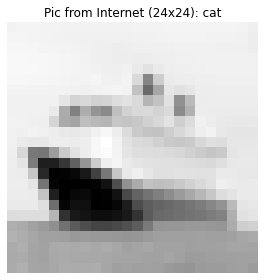

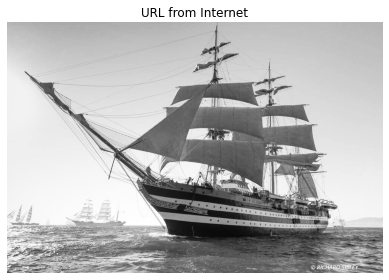

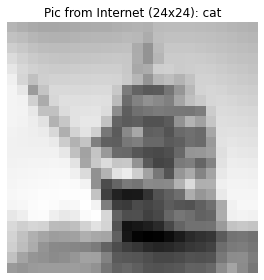

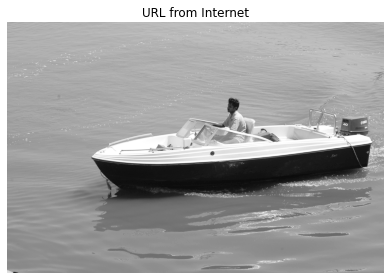

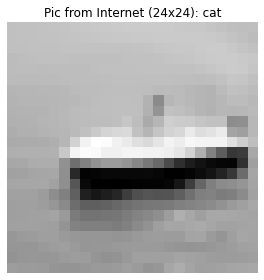

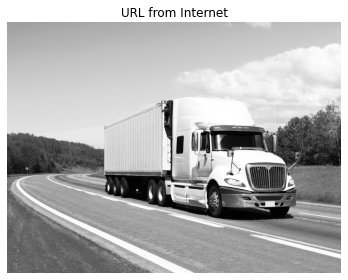

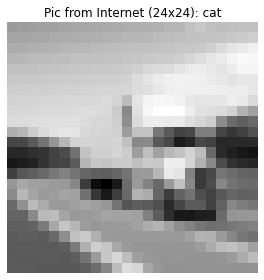

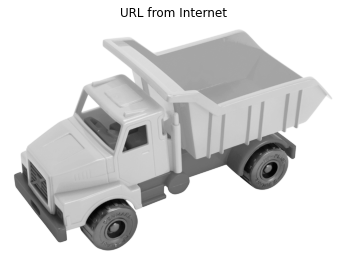

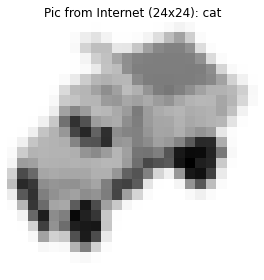

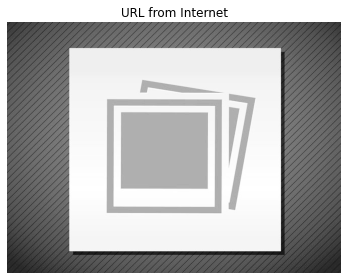

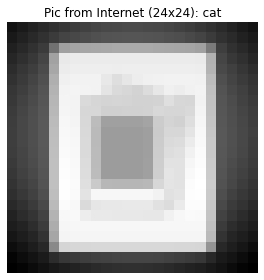

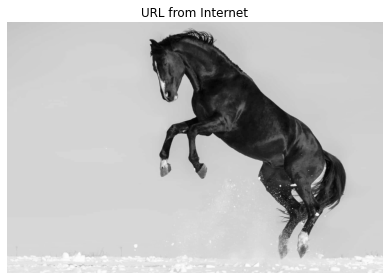

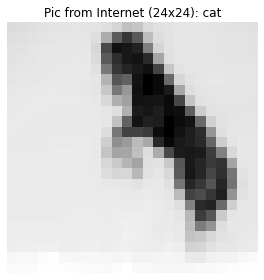

In [25]:
predict_urls = [
    'http://www.torontozoo.com/adoptapond/guide_images/Green%20Frog.jpg', #frog
    'https://cdn.cnn.com/cnnnext/dam/assets/160205192735-01-best-cruise-ships-disney-dream-super-169.jpg', #ship
    'https://www.sailboston.com/wp-content/uploads/2016/11/amerigo-vespucci.jpg', #ship
    'https://upload.wikimedia.org/wikipedia/commons/d/d9/Motorboat_at_Kankaria_lake.JPG', #ship
    'https://media.wired.com/photos/5b9c3d5e7d9d332cf364ad66/master/pass/AV-Trucks-187479297.jpg', #truck
    'https://images.schoolspecialty.com/images/1581176_ecommfullsize.jpg', #truck
    'https://img.purch.com/w/660/aHR0cDovL3d3dy5saXZlc2NpZW5jZS5jb20vaW1hZ2VzL2kvMDAwLzEwNC84MTkvb3JpZ2luYWwvY3V0ZS1raXR0ZW4uanBn', # cat
    'https://thehorse.com/wp-content/uploads/2017/01/iStock-510488648.jpg' #horse
]

predicted_labels = []
for url in predict_urls:
    pred = predict_img_url(url)
    predicted_labels.append(pred)

print(predicted_labels)